0. Install and Import Dependencies

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

1. Building Data Loading Functions

In [7]:
import gdown

In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=be80ba8d-78ce-4ad9-9135-1c1007ed915c
To: /Users/sneha/Desktop/jupNB/project2/data.zip
100%|████████████████████████████████████████| 423M/423M [00:07<00:00, 57.4MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [10]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32)/ std

In [13]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [15]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [17]:
char_to_num(["h", "e", "l", "l", "o"])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 8,  5, 12, 12, 15])>

In [19]:
num_to_char([ 8,  5, 12, 12, 15])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'h', b'e', b'l', b'l', b'o'], dtype=object)>

In [21]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'),(-1)))[1:]

In [23]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [25]:
test_path =  'data/s1/bbaf2n.mpg' #'.\\data\\s1\\bbal6n.mpg'

In [27]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8')

'data/s1/bbaf2n.mpg'

In [29]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

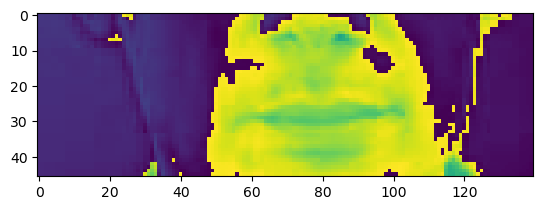

In [31]:
plt.imshow(frames[0])

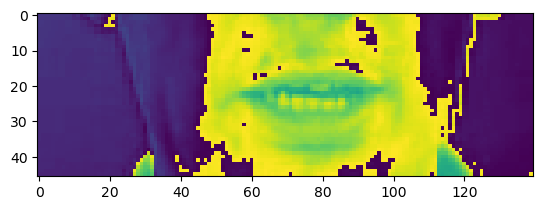

In [33]:
plt.imshow(frames[50])

In [35]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

2. Create Data Pipeline

In [38]:
from matplotlib import pyplot as plt

In [40]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [42]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [44]:
frames, alignments = data.as_numpy_iterator().next()

In [45]:
len(frames)

2

In [48]:
alignments

array([[ 2,  9, 14, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 14, 39, 26,
         5, 18, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [16, 12,  1,  3,  5, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39, 16,
        39, 14,  9, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [50]:
test = data.as_numpy_iterator()

In [52]:
val = test.next()

In [53]:
frames_for_gif = [frame.astype(np.uint8) for frame in val[0]]

In [56]:
print(val[0][1].shape)
print(val[0][1].dtype)

(75, 46, 140, 1)
float32


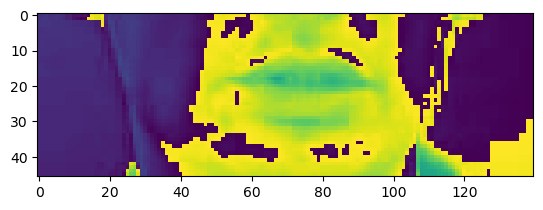

In [58]:
#0: videos, 0: 1st video out of the batch, 0: return the first frame in the video
plt.imshow(val[0][0][0])

In [60]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at d six now'>

3. Design the Deep Neural Network 

In [63]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [65]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Reshape((5 * 17 * 75,))))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [70]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666666666666666666666666666666666666666666666666666666669999999999999999'>

In [71]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'666666666666666666666666666666666666666666666666666666666669999999999999999'>

In [72]:
model.input_shape

(None, 75, 46, 140, 1)

In [73]:
model.output_shape

(None, 75, 41)

4. Setup Training Options and Train

In [75]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [76]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [77]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        #self.dataset = dataset.as_numpy_iterator()
        self.dataset = dataset
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [79]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [88]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True) 

In [90]:
schedule_callback = LearningRateScheduler(scheduler)

In [92]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  5/450 ━━━━━━━━━━━━━━━━━━━━ 2:05:11 17s/step - loss: 75.9904

5. Make a prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

4. Test on a video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]